In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import math

Num GPUs Available:  0


In [2]:
data, metadata = tfds.load('emnist/letters', as_supervised=True, with_info=True)
metadata

tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/letters/3.0.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST Letters
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='C:\\Users\\feder\\tensorflow_datasets\\emnist\\letters\\3.0.0',
    file_format=tfrecord,
    download_size=535.73 MiB,
    dataset_size=44.14 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
    }),
    

In [3]:
input_shape = (28, 28, 1)

classes = metadata.features["label"].names
num_classes = len(classes)

tam_training_data= metadata.splits["train"].num_examples
tam_testing_data = metadata.splits["test"].num_examples

batch_size = 64
epochs = 20

In [4]:
# Normalizar datos
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

training_data, testing_data = data["train"], data["test"]

training_data = training_data.map(normalize)
testing_data = testing_data.map(normalize)

training_data = training_data.cache()
testing_data = testing_data.cache()

training_data = training_data.repeat().shuffle(tam_training_data).batch(batch_size)
testing_data = testing_data.batch(batch_size)



In [5]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [6]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer="adam", metrics=["accuracy"])

In [7]:
history = model.fit(training_data, epochs=epochs, steps_per_epoch=math.ceil(tam_training_data/batch_size), validation_data=testing_data)

Epoch 1/20
1388/1388 [==============================] - 61s 40ms/step - loss: 0.5391 - accuracy: 0.8283 - val_loss: 0.3105 - val_accuracy: 0.8912
Epoch 2/20
1388/1388 [==============================] - 50s 36ms/step - loss: 0.2646 - accuracy: 0.9102 - val_loss: 0.2822 - val_accuracy: 0.9032
Epoch 3/20
1388/1388 [==============================] - 52s 37ms/step - loss: 0.2214 - accuracy: 0.9244 - val_loss: 0.2245 - val_accuracy: 0.9230
Epoch 4/20
1388/1388 [==============================] - 47s 34ms/step - loss: 0.1941 - accuracy: 0.9313 - val_loss: 0.2128 - val_accuracy: 0.9247
Epoch 5/20
1388/1388 [==============================] - 50s 36ms/step - loss: 0.1729 - accuracy: 0.9380 - val_loss: 0.2252 - val_accuracy: 0.9220
Epoch 6/20
1388/1388 [==============================] - 51s 37ms/step - loss: 0.1677 - accuracy: 0.9390 - val_loss: 0.2280 - val_accuracy: 0.9202
Epoch 7/20
1388/1388 [==============================] - 48s 35ms/step - loss: 0.1521 - accuracy: 0.9436 - val_loss: 0.2045 -

Text(0.5, 1.0, 'Accuracy')

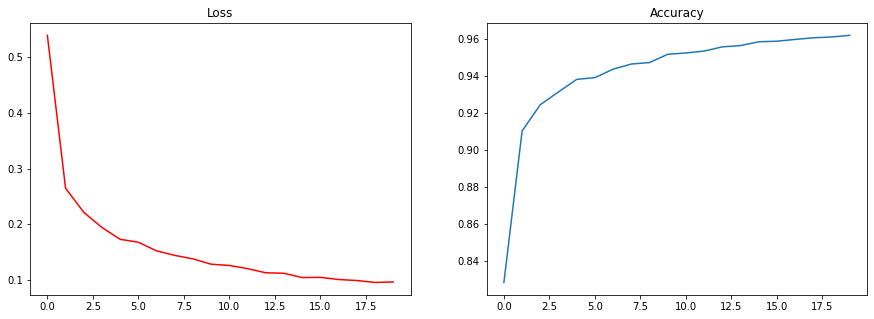

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

ax[0].plot(history.history["loss"], color="r")
ax[0].set_title("Loss")

ax[1].plot(history.history["accuracy"])
ax[1].set_title("Accuracy")

2/2 [==============================] - 0s 8ms/step


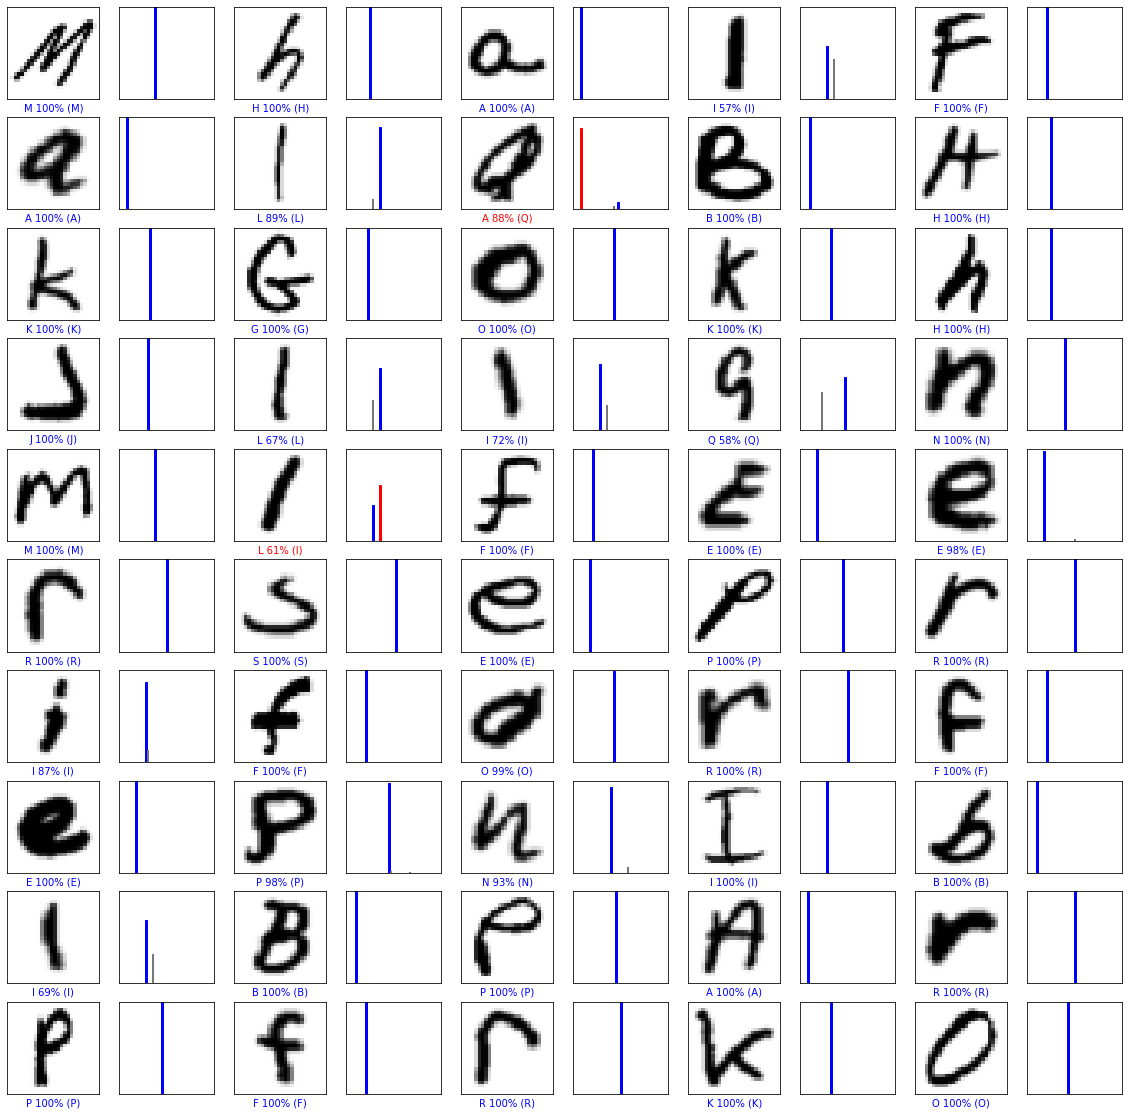

In [9]:
for test_images, test_labels in testing_data.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)
  
def draw_images(i, arr_predictions, labels, images):
  arr_predictions, label, img = arr_predictions[i], labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0].T, cmap=plt.cm.binary)

  prediction_label = np.argmax(arr_predictions)
  if prediction_label == label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(chr(int(classes[prediction_label])+64),
                                100*np.max(arr_predictions),
                                chr(int(classes[label])+64)),
                                color=color)
  
def draw_prediction_graphic(i, arr_predictions, label):
  arr_predictions, label = arr_predictions[i], label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  graphic = plt.bar(range(num_classes), arr_predictions, color="#777777")
  plt.ylim([0, 1]) 
  prediction_label = np.argmax(arr_predictions)
  
  graphic[prediction_label].set_color('red')
  graphic[label].set_color('blue')
  
rows = 10
columns = 5
num_images = rows*columns
plt.figure(figsize=(2*2*columns, 2*rows))
for i in range(num_images):
  plt.subplot(rows, 2*columns, 2*i+1)
  draw_images(i, predictions, test_labels, test_images)
  plt.subplot(rows, 2*columns, 2*i+2)
  draw_prediction_graphic(i, predictions, test_labels)